# Reconocimiento óptico de caracteres

![Un robot leyendo un periódico](../images/ocr.jpg)

Uno de los desafíos más habituales de Computer Vision es detectar e interpretar el texto de una imagen. Este tipo de procesamiento suele conocerse como *reconocimiento óptico de caracteres* (OCR)

## Usar el servicio Computer Vision para encontrar el texto de una imagen

El servicio **Computer Vision** de Cognitive Services permite realizar tareas de OCR, como estas:

- Una API de **OCR** que puede usar para leer el texto en varios idiomas. La API se puede usar de forma sincrónica y es muy útil cuando se necesita detectar y leer una pequeña cantidad de texto de una imagen.
- Una **Read** API optimizada para documentos más grandes. Esta API se usa de forma asincrónica y se puede utilizar para texto impreso y escrito a mano.

Para usar este servicio, cree un recurso de **Computer Vision** o un recurso de **Cognitive Services**.

Si no lo ha hecho aún, cree un recurso de **Cognitive Services** en su suscripción de Azure.

> **Nota**: Si ya tiene un recurso de Cognitive Services, abra su página de **Inicio rápido** en Azure Portal y copie la clave y el punto de conexión en la siguiente celda. En caso contrario, siga estos pasos para crear uno.

1. En la pestaña de otro explorador, abra Azure Portal (https://portal.azure.com) e inicie sesión con su cuenta de Microsoft.

2. Haga clic en el botón **&#65291;Crear un recurso**, busque *Cognitive Services* y cree un recurso de **Cognitive Services** con esta configuración:
    - **Suscripción**: *su suscripción de Azure*.
    - **Grupo de recursos**: *seleccione o cree un grupo de recursos con un nombre único.*
    - **Región**: *seleccione cualquier región disponible*:
    - **Nombre**: *escriba un nombre único*.
    - **Plan de tarifa**: S0
    - **Confirmo que he leído y comprendido las notificaciones**: seleccionado.
3. Espere a que la implementación finalice. Vaya al recurso de Cognitive Services y, en la página **Información general**, haga clic en el vínculo para administrar las claves del servicio. Necesitará el punto de conexión y las claves para conectarse a su recurso de Cognitive Services desde aplicaciones de cliente.

### Obtener la clave y el punto de conexión de un recurso de Cognitive Services

Para usar su recurso de Cognitive Services, las aplicaciones de cliente necesitan su clave de autenticación y su punto de conexión:

1. En Azure Portal, en la página **Claves y punto de conexión** de su recurso de Cognitive Services, copie la **Key1** de su recurso y péguela en el siguiente código, en sustitución de **YOUR_COG_KEY**.
2. Copie el **Punto de conexión** de su recurso y péguelo en el siguiente código, en sustitución de **YOUR_COG_ENDPOINT**.
3. Haga clic en **Run cell** (&#9655;), a la izquierda de la celda siguiente, para ejecutar su código.

## Instalamos la Biblioteca de Computer Vision

In [1]:
!pip install --upgrade azure-cognitiveservices-vision-computervision

Requirement already up-to-date: azure-cognitiveservices-vision-computervision in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (0.9.0)


## Asignamos nuestras credenciales
* Obtenidas del portal de Azure

In [2]:
key = ''
endpoint = ''

#print('Ready to use cognitive services at {} using key {}'.format(endpoint, key))

Ahora que ha configurado la clave y el punto de conexión, puede usar su recurso de Computer Vision para extraer el texto de una imagen.

Empezaremos con la API de **OCR**, que permite analizar de forma sincrónica una imagen y leer el texto que contiene. En este caso, tenemos una imagen publicitaria de la empresa ficticia Northwind Traders que incluye algo de texto. Ejecute la celda siguiente para leerlo. 

## Importamos las bibliotecas

In [3]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
%matplotlib inline

## Autenticamos el cliente

In [6]:
# Obtener un cliente del servicio Computer Vision
client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(key))

## Cargamos la Imagen

In [5]:
# Lectura del archivo de imagen
image_path = os.path.join('../data', 'ocr', 'advert.jpg')
image_stream = open(image_path, "rb")

## Analizamos la imagen en búsqueda de texto

Northwind Traders
Fresh produce,
friendly service
Open 7 days a week


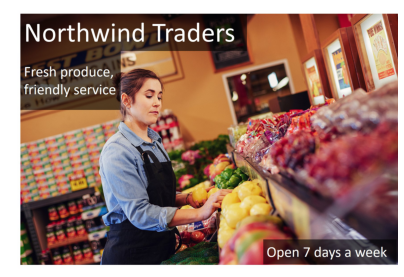

In [7]:
# Usar el servicio Computer Vision para encontrar el texto de la imagen
read_results = client.recognize_printed_text_in_stream(image_stream)

# Procesar el texto línea a línea
for region in read_results.regions:
    for line in region.lines:

        # Lea las palabras en la línea de texto
        line_text = ''
        for word in line.words:
            line_text += word.text + ' '
        print(line_text.rstrip())

# Abrir la imagen para mostrarla.
fig = plt.figure(figsize=(7, 7))
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
plt.axis('off')
plt.imshow(img)

El texto de la imagen está organizado en una estructura jerárquica de regiones, líneas y palabras. El código lee esta estructura para obtener los resultados.

En los resultados, podemos ver el texto leído encima de la imagen. 

## Mostrar cuadros de límite

Los resultados también incluyen las coordenadas del *cuadro de límite* de las líneas de texto y las palabras individuales encontradas en la imagen. Ejecute la siguiente celda para ver los cuadros de límite de las líneas de texto de la imagen publicitaria utilizada anteriormente.

## Cargamos la imagen

In [8]:
# Abrir la imagen para mostrarla.
fig = plt.figure(figsize=(7, 7))
img = Image.open(image_path)
draw = ImageDraw.Draw(img)

<Figure size 504x504 with 0 Axes>

## Analizamos la Imagen

Northwind Traders
Fresh produce,
friendly service
Open 7 days a week


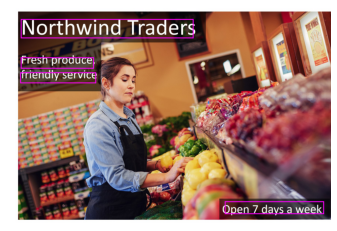

In [9]:
# Procesar el texto línea a línea
for region in read_results.regions:
    for line in region.lines:

        # Muestre la posición de la línea de texto
        l,t,w,h = list(map(int, line.bounding_box.split(',')))
        draw.rectangle(((l,t), (l+w, t+h)), outline='magenta', width=5)

        # Lea las palabras en la línea de texto
        line_text = ''
        for word in line.words:
            line_text += word.text + ' '
        print(line_text.rstrip())

# Mostrar la imagen con la ubicación del texto resaltada
plt.axis('off')
plt.imshow(img)

En el resultado, el cuadro de límite de cada línea de texto aparece como un rectángulo en la imagen.

## Usar la Read API

La API de OCR utilizada anteriormente es útil para imágenes con poco texto. Cuando se necesita leer una cantidad mayor de texto, como pasa con los documentos escaneados, puede usar la **Read** API. Se trata de un proceso compuesto por varios pasos:

1. Envíe una imagen al servicio Computer Vision para leerla y analizarla de forma asincrónica.
2. Espere a que se complete la operación de análisis.
3. Recupere los resultados del análisis.

Ejecute la siguiente celda para usar este proceso y leer el texto de una carta escaneada dirigida al director de una tienda de Northwind Traders.

## Importamos las bibliotecas necesarias

In [12]:
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
import time

## Cargamos la imagen

In [13]:
# Lectura del archivo de imagen
image_path = os.path.join('../data', 'ocr', 'letter.jpg')
image_stream = open(image_path, "rb")

## Procesamos la Imagen

January 23rd 2020
For the attention of:
The manager
Northwind Traders
123 Any Street
Bellevue, WA
Dear Sir or Madam,
I am writing to thank you for the fantastic service I received at
your store on January 20th. The store assistant who helped me was
extremely pleasant and attentive; and took the time to find all of
the fresh produce I needed.
I've always found the quality of the produce in your store to be
high, and the prices to be competitive; and the helpfulness of your
employees is another reason I will continue to remain a loyal
Northwind Traders customer.
Sincerely,
A Customer
A. Customer




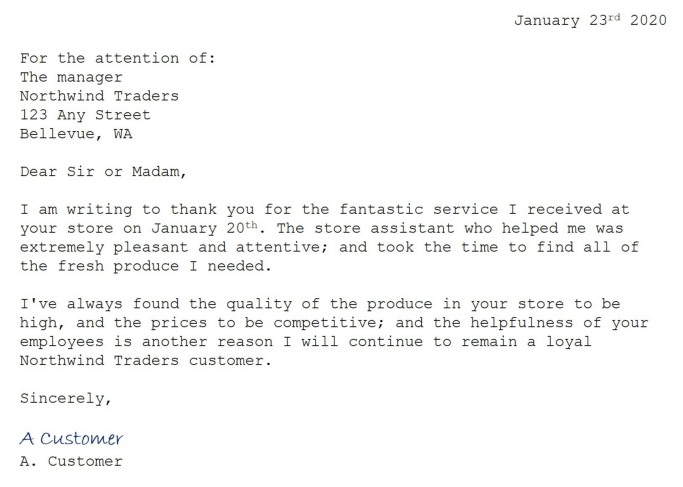

In [14]:
# Enviar una solicitud para leer el texto escrito de la imagen y obtener el ID de operación
read_operation = client.read_in_stream(image_stream,
                                                      raw=True)
operation_location = read_operation.headers["Operation-Location"]
operation_id = operation_location.split("/")[-1]

# Esperar hasta que se termine la operación asincrónica
while True:
    read_results = client.get_read_result(operation_id)
    if read_results.status not in [OperationStatusCodes.running]:
        break
    time.sleep(1)

# Una vez completada la operación, procesar el texto línea a línea
if read_results.status == OperationStatusCodes.succeeded:
    for result in read_results.analyze_result.read_results:
        for line in result.lines:
            print(line.text)

# Abrir la imagen y mostrarla.
print('\n')
fig = plt.figure(figsize=(12,12))
img = Image.open(image_path)
plt.axis('off')
plt.imshow(img)

Revise los resultados. Encontrará una transcripción completa de la carta, que contiene en su mayoría texto impreso con una firma a mano. La imagen original de la carta aparece debajo de los resultados del OCR (quizá deba desplazarse hacia abajo para verla).

## Leer texto manuscrito

En el ejemplo anterior, la solicitud para analizar la imagen especificaba un modo de reconocimiento de texto que optimizaba la operación para texto *impreso*. A pesar de esto, se ha leído la firma manuscrita.

Esta capacidad de leer texto manuscrito es muy útil. Por ejemplo, supongamos que ha escrito una nota con una lista de la compra y quiere usar una aplicación de su teléfono para leer la nota y transcribirla.

Ejecute la siguiente celda para ver un ejemplo de una operación de lectura de una lista de la compra manuscrita.

## Cargamos la Imagen

In [15]:
# Lectura del archivo de imagen
image_path = os.path.join('../data', 'ocr', 'note.jpg')
image_stream = open(image_path, "rb")

## Procesamos la Imagen

Shopping List
Non- Fat milk
Bread
Eggs




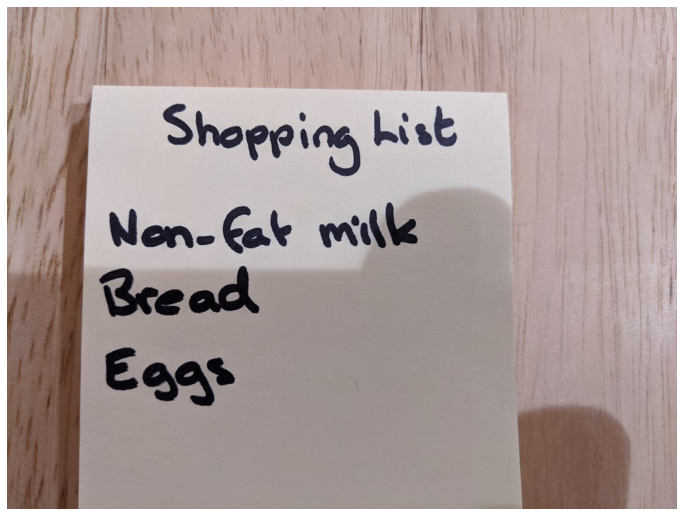

In [16]:
# Enviar una solicitud para leer el texto escrito de la imagen y obtener el ID de operación
read_operation = client.read_in_stream(image_stream,
                                                      raw=True)
operation_location = read_operation.headers["Operation-Location"]
operation_id = operation_location.split("/")[-1]

# Esperar hasta que se termine la operación asincrónica
while True:
    read_results = client.get_read_result(operation_id)
    if read_results.status not in [OperationStatusCodes.running]:
        break
    time.sleep(1)

# Una vez completada la operación, procesar el texto línea a línea
if read_results.status == OperationStatusCodes.succeeded:
    for result in read_results.analyze_result.read_results:
        for line in result.lines:
            print(line.text)

# Abrir la imagen y mostrarla.
print('\n')
fig = plt.figure(figsize=(12,12))
img = Image.open(image_path)
plt.axis('off')
plt.imshow(img)

## Más información

Para obtener más información sobre cómo usar el servicio Computer Vision para realizar OCR, consulte la [documentación de Computer Vision](https://docs.microsoft.com/es-es/azure/cognitive-services/computer-vision/concept-recognizing-text)